### 0.パッケージのインストール

In [1]:
import sys
import os
sys.path.append("../src")

import torch
import matplotlib.pyplot as plt
import numpy as np

from dataset import CustomSegmentationDataset, TestDataset
from utils import DatasetSplitter, JsonUtils
from model import get_deeplabv3plus
from train import train_model
from infer import inference, InferenceVisualizer
import rasterio
import pickle

### 2. データセットの準備・可視化

In [2]:
## 学習用データを分割して学習用(train)と評価用(val)に分ける
splitter = DatasetSplitter(
    image_dir="../data/raw_train/images",
    annotation_file="../data/raw_train/annotations/train_segmentation_annotations.json",
    output_dir="../data"
)

splitter.split(test_size=0.2)

✅ Split completed. Train: 2122, Val: 531


In [3]:
# ファイル読み込み先の指定
train_img_dir = "../data/train/images"
train_ann_file = "../data/train/annotations/annotations.json"
val_img_dir = "../data/val/images"
val_ann_file = "../data/val/annotations/annotations.json"

# annotationラベルの指定
label_map = {
    "background": 0,
    "vacant_lot": 1,
}

train_dataset = CustomSegmentationDataset(train_img_dir, train_ann_file, label_map, transform=None, target_size=(256, 256))
val_dataset = CustomSegmentationDataset(val_img_dir, val_ann_file, label_map, transform=None, target_size=(256, 256))

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


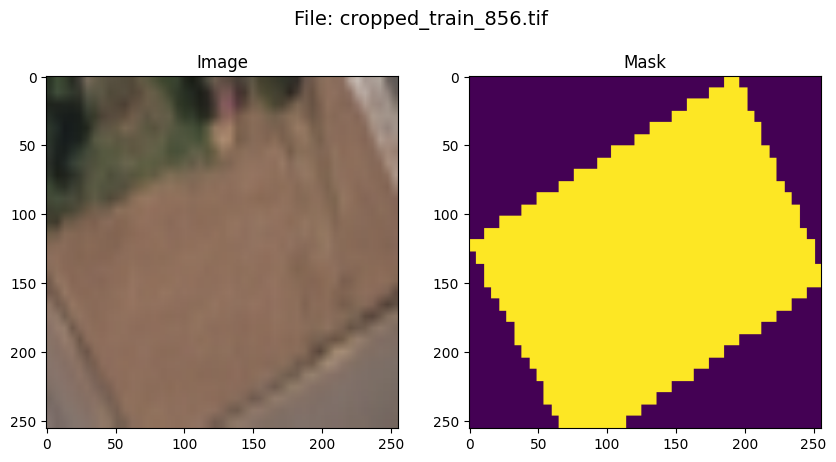

In [4]:
# サンプル画像とマスクの可視化
idx = 1

img, mask = train_dataset[idx]
file_name = train_dataset.annotations_data[idx]['file_name']

plt.figure(figsize=(10,5))
plt.suptitle(f"File: {file_name}", fontsize=14) 
plt.subplot(1,2,1)
plt.title("Image")
plt.imshow(img.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

### 3. モデルの構築

In [7]:
num_classes = 2  # クラス数に応じて変更
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3plus(num_classes).to(device)

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 4.学習

In [ ]:
# from torch.utils.data import DataLoader

# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# num_epochs = 10
# model, history = train_model(model, train_loader, val_loader, num_epochs=num_epochs, device=device)

# # モデルの保存
# model_path = "../models/model.pth"
# torch.save(model.state_dict(), model_path) # モデルの state_dict（重み）を保存

# # 学習履歴の保存
# history_path = "../models/history.pth"
# torch.save(history, 'history.pth')

In [9]:
# モデルの読み込み
model_path = "../models/model.pth"
model.load_state_dict(torch.load(model_path))

# 学習履歴の読み込み
history_path = "../models/history.pth"
history = torch.load(history_path)

### 5. 検証データで推論

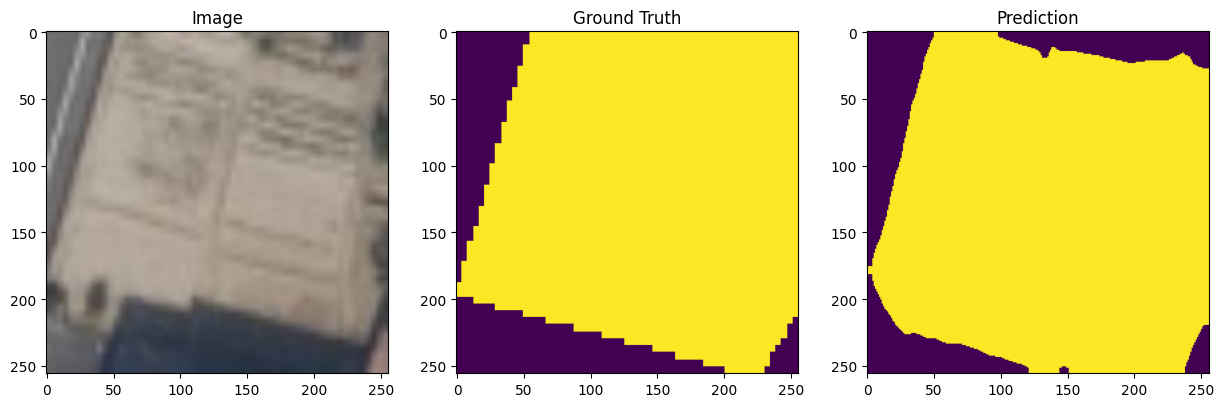

In [10]:
val_img, val_mask = val_dataset[0]
pred_mask = inference(model, val_img, device=device)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(val_img.permute(1, 2, 0).cpu().numpy()) # 画像を(H, W, C)に戻す
plt.subplot(1,3,2)
plt.title("Ground Truth")
plt.imshow(val_mask)
plt.subplot(1,3,3)
plt.title("Prediction")
plt.imshow(pred_mask)
plt.show()

In [14]:
# 推論を実行して結果を保存
pred_masks = []
for idx in range(len(val_dataset)):
    val_img, _ = val_dataset[idx]
    pred_mask = inference(model, val_img, device=device)
    pred_masks.append(pred_mask)

In [15]:
# 推論結果の可視化と保存
visualizer = InferenceVisualizer(val_dataset)

# 画像、正解マスク、予測マスクを並べて保存
visualizer.visualize_and_save(pred_masks, "../data/val/predictions")

推論結果を ../data/val/predictions に保存しました。


### 7. 追加：学習曲線の可視化（任意）

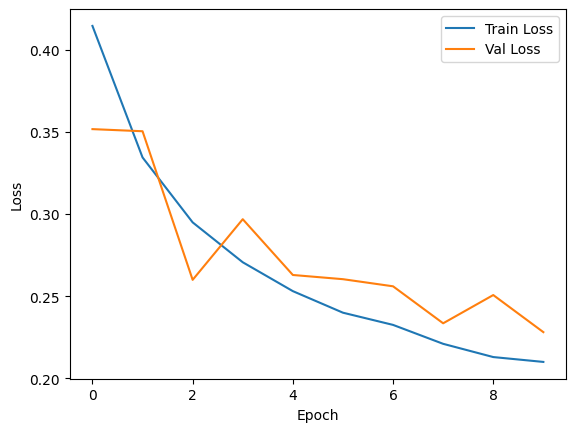

In [13]:
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 8.テストデータを推論

In [16]:
num_classes = 2  # クラス数に応じて変更
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_deeplabv3plus(num_classes).to(device)

# モデルの読み込み
model_path = "../models/model.pth"
model.load_state_dict(torch.load(model_path))

# 学習履歴の読み込み
history_path = "../models/history.pth"
history = torch.load(history_path)

In [23]:
# ファイルの入出力先の指定
test_img_file = "../data/test/images" # テスト画像の入力元
test_ann_file = "../data/test/annotations/predictions.json" # テストの推論結果の出力先

# annotationラベルの指定
label_map = {
    "background": 0,
    "vacant_lot": 1,
}

# テストデータセットの作成
test_dataset = TestDataset(test_img_file, transform=None, target_size=(256, 256))

In [25]:
# 推論を実行して結果をjson保存
# test_masks = []

# for idx in range(len(test_dataset)):
#     test_img, _ = test_dataset[idx]
#     test_mask = inference(model, test_img, device=device)
#     test_masks.append(test_mask)

# 推論結果を保存するためのリスト
pred_masks = []
file_names = []
widths = []
heights = []

# 推論を実行
for idx in range(len(test_dataset)):
    test_img, file_name = test_dataset[idx]
    pred_mask = inference(model, test_img, device=device)

    # 画像サイズを取得
    image_path = os.path.join(test_dataset.image_dir, file_name)
    with rasterio.open(image_path) as src:
        width = src.width
        height = src.height

    # 結果を追加
    pred_masks.append(pred_mask)
    file_names.append(file_name)
    widths.append(width)
    heights.append(height)
    
# すべての推論結果を1つのJSONファイルに保存
output_json_path = "../data/test/annotations/predictions.json"
JsonUtils.mask_to_json(
    masks=pred_masks,
    file_names=file_names,
    output_path=output_json_path,
    widths=widths,
    heights=heights
)

d:\python_workspace\detect-emptylots\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [26]:
# 推論結果を用いたテストデータセットを作成
test_result = CustomSegmentationDataset(test_img_file, test_ann_file, label_map, transform=None, target_size=(256, 256))

# 推論を実行して結果を保存
test_masks = []
for idx in range(len(test_result)):
    test_img, _ = test_result[idx]
    test_mask = inference(model, test_img, device=device)
    test_masks.append(test_mask)


# 推論結果の可視化と保存
test_visualizer = InferenceVisualizer(test_result)

# 画像、正解マスク、予測マスクを並べて保存
test_visualizer.visualize_and_save(test_masks, "../data/test/predictions")

推論結果を ../data/test/predictions に保存しました。
